# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

For an introduction into feature extraction, see the previous notebook `feature_extraction.ipynb`.

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. You may have already downloaded this dataset from the previous notebook, `7a_transfer_learning.ipynb`. If not, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

We'll start by importing the relevant Keras libraries that we'll be using.

In [3]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [4]:
# Setup tensorflow GPUs
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(gpu_devices)

[]


In [5]:
# Let's look at the processor we're running
!nvidia-smi

Sun Feb 13 11:30:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8     7W /  N/A |     13MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [20]:
# Can start here, load data to do classification
# Need to run load_image above

import pickle
from keras.preprocessing import image

#from google.colab import drive
#drive.mount('/content/gdrive')
#[images, pca_features, pca, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'rb'))
#[images, pca_features, pca, imageToCategory] = pickle.load(open('../../../101_ObjectCategories/CalTechFeatures.p', 'rb'))
[images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'rb'))

print(dir())
print(len(images))

['In', 'Model', 'Out', '_', '_11', '_12', '_6', '_9', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'closestForImagePath', 'concat_image', 'correct', 'count', 'decode_predictions', 'distance', 'elap', 'exit', 'get_closest_images', 'get_concatenated_images', 'get_ipython', 'i', 'idx', 'idx_closest', 'ii', 'image', 'imageToCategory', 'image_path', 'images', 'img', 'keras', 'key', 'load_image', 'np', 'os', 'pca', 'pcaFull', 'pca_features', 'pca_features_full', 'pickle', 'plt', 'preprocess_input', 'queryCategory', 'query_image', 'query_image_idx', 'quit', 'random', 'results_image', 'similar_idx', 'sumCorrect', 'sumCorrectByCategory', 'sumTotal', 'sumWas', 't0', 'thumbs', 'time', 'totalByCategory', 'tota

Now let's see what the PCA version of the feature vector above looks like.

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

7442
<class 'dict'>
<class 'list'>
7442
1164
Leopards


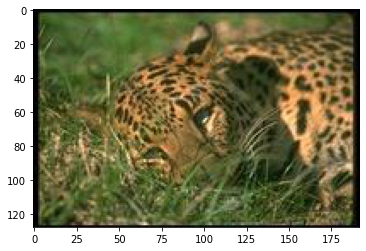

In [21]:
import random
from keras.preprocessing import image

print(len(imageToCategory))
print(type(imageToCategory))
print(type(images))
print(len(images))

# grab a random query image
query_image_idx = int(len(images) * random.random())
print(query_image_idx)
print(imageToCategory[images[query_image_idx]])

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [22]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [23]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

Leopards
Leopards
Leopards
Leopards
Leopards


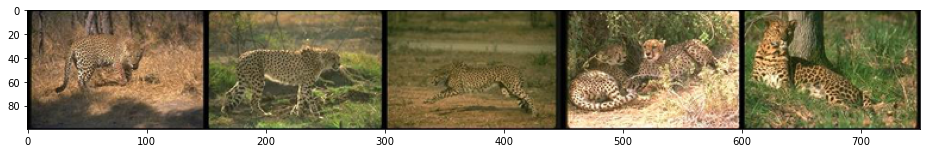

In [24]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    print(imageToCategory[images[idx]])
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [25]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

query category= airplanes
   match category= airplanes
   match category= airplanes
   match category= airplanes
   match category= airplanes
   match category= airplanes


Text(0.5, 1.0, 'result images')

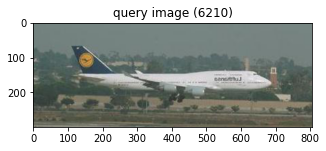

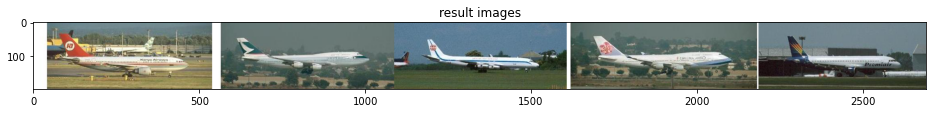

In [26]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

And again...

query category= metronome
   match category= scissors
   match category= metronome
   match category= scissors
   match category= cellphone
   match category= dragonfly


Text(0.5, 1.0, 'result images')

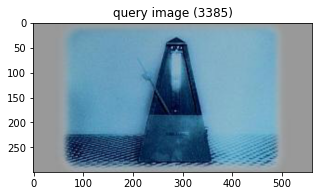

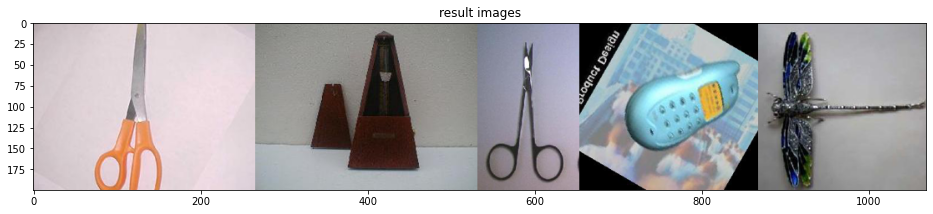

In [27]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [28]:
# Look at performance
import time
t0 = time.time()

sumCorrectByCategory = {}
totalByCategory = {}
closestForImagePath = {}
count=0
for i, image_path in enumerate(images):
  queryCategory=imageToCategory[image_path]
  if queryCategory not in sumCorrectByCategory:
    sumCorrectByCategory[queryCategory] = 0
    totalByCategory[queryCategory] = 0
  idx_closest = get_closest_images(i)
  closestForImagePath[image_path] = idx_closest
  if queryCategory == imageToCategory[images[idx_closest[0]]]:
    #print(queryCategory, ' ', imageToCategory[images[idx_closest[0]]], ' correct!')
    sumWas = sumCorrectByCategory[queryCategory]
    sumCorrectByCategory[queryCategory] = sumWas + 1
  #else:
  #  print(queryCategory, ' ', imageToCategory[images[idx_closest[0]]], ' wrong!')

  totalWas = totalByCategory[queryCategory]
  totalByCategory[queryCategory] = totalWas + 1

  count += 1
  if count % 500 == 0:
    print("analyzing image %d / %d" % (i, len(images)))
    #break

print(sumCorrectByCategory)
print(totalByCategory)

elap = time.time() - t0;
print("Total time: %5.4f seconds." % elap)

analyzing image 499 / 7442
analyzing image 999 / 7442
analyzing image 1499 / 7442
analyzing image 1999 / 7442
analyzing image 2499 / 7442
analyzing image 2999 / 7442
analyzing image 3499 / 7442
analyzing image 3999 / 7442
analyzing image 4499 / 7442
analyzing image 4999 / 7442
analyzing image 5499 / 7442
analyzing image 5999 / 7442
analyzing image 6499 / 7442
analyzing image 6999 / 7442
{'schooner': 48, 'brain': 73, 'binocular': 30, 'chair': 40, 'tick': 47, 'cup': 48, 'pyramid': 48, 'llama': 64, 'cougar_body': 37, 'ibis': 65, 'euphonium': 61, 'saxophone': 38, 'okapi': 36, 'emu': 48, 'lotus': 46, 'butterfly': 63, 'buddha': 77, 'soccer_ball': 64, 'Leopards': 98, 'inline_skate': 28, 'pizza': 49, 'chandelier': 89, 'beaver': 33, 'ewer': 80, 'stop_sign': 64, 'elephant': 55, 'gerenuk': 28, 'cellphone': 56, 'sunflower': 75, 'wheelchair': 49, 'stegosaurus': 48, 'flamingo_head': 34, 'dragonfly': 54, 'octopus': 14, 'Motorbikes': 200, 'accordion': 55, 'panda': 31, 'wild_cat': 19, 'ferry': 67, 'can

In [29]:
import pickle

#pickle.dump([sumCorrectByCategory, totalByCategory, closestForImagePath], open('./gdrive/MyDrive/101_ObjectCategories/metrics300.p', 'wb'))

[sumCorrectByCategory, totalByCategory, closestForImagePath[images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/metrics300.p', 'rb'))

In [32]:
sumCorrect = 0
sumTotal = 0
labels = []
accuracies = []
for key in sumCorrectByCategory.keys():
  accuracy = sumCorrectByCategory[key]/totalByCategory[key]
  sumCorrect = sumCorrect + sumCorrectByCategory[key]
  sumTotal = sumTotal + totalByCategory[key]
  print("%s = %4.2f" % (key, accuracy))
  labels.append(key)
  accuracies.append(accuracy)

print("\nOverall score= %4.2f" % (sumCorrect/sumTotal))

schooner = 0.76
brain = 0.91
binocular = 0.91
chair = 0.65
tick = 0.96
cup = 0.84
pyramid = 0.84
llama = 0.82
cougar_body = 0.79
ibis = 0.93
euphonium = 0.95
saxophone = 0.95
okapi = 0.92
emu = 0.91
lotus = 0.70
butterfly = 0.69
buddha = 0.91
soccer_ball = 1.00
Leopards = 1.00
inline_skate = 0.90
pizza = 0.92
chandelier = 0.83
beaver = 0.72
ewer = 0.94
stop_sign = 1.00
elephant = 0.86
gerenuk = 0.82
cellphone = 0.95
sunflower = 0.88
wheelchair = 0.83
stegosaurus = 0.81
flamingo_head = 0.76
dragonfly = 0.79
octopus = 0.40
Motorbikes = 1.00
accordion = 1.00
panda = 0.82
wild_cat = 0.56
ferry = 1.00
cannon = 0.77
ketch = 0.76
cougar_face = 0.90
lamp = 0.77
revolver = 0.96
car_side = 1.00
gramophone = 0.65
crocodile_head = 0.61
starfish = 0.94
wrench = 0.72
joshua_tree = 0.94
crocodile = 0.46
windsor_chair = 0.91
metronome = 0.81
snoopy = 0.69
rhino = 0.90
watch = 0.98
water_lilly = 0.62
grand_piano = 0.97
brontosaurus = 0.42
sea_horse = 0.63
pigeon = 0.96
lobster = 0.56
yin_yang = 0.87
an

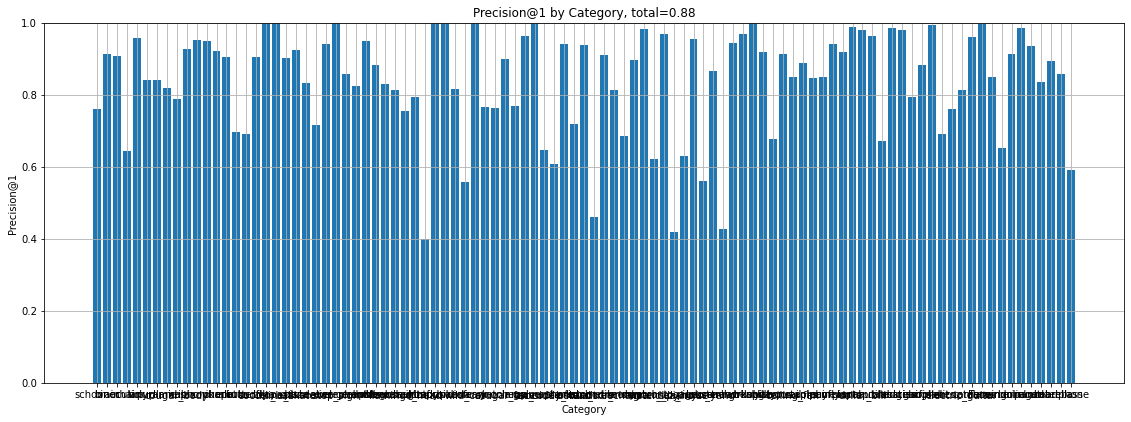

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.bar(labels, accuracies)
ax.set_xlabel('Category')
ax.set_ylabel('Precision@1')
ax.set_title('Precision@1 by Category, total=%4.2f' % (sumCorrect/sumTotal))
plt.grid()

plt.show()

In [45]:
def get_closest_images_pca(query_image_idx, pca_feat, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_feat ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

SyntaxError: non-default argument follows default argument (2119862905.py, line 1)

In [ ]:
# Look at performance
import time
t0 = time.time()

sumCorrectByCategoryAll = {}
totalByCategoryAll = {}
closestForImagePathAll = {}
for i, image_path in enumerate(images):
  queryCategory=imageToCategory[image_path]
  if queryCategory not in sumCorrectByCategory:
    sumCorrectByCategoryAll[queryCategory] = 0
    totalByCategoryAll[queryCategory] = 0
  idx_closest = get_closest_images(i)
  closestForImagePathAll[image_path] = idx_closest
  if queryCategory == imageToCategory[images[idx_closest[0]]]:
    #print(queryCategory, ' ', imageToCategory[images[idx_closest[0]]], ' correct!')
    sumWas = sumCorrectByCategoryAll[queryCategory]
    sumCorrectByCategoryAll[queryCategory] = sumWas + 1
  #else:
  #  print(queryCategory, ' ', imageToCategory[images[idx_closest[0]]], ' wrong!')

  totalWas = totalByCategoryAll[queryCategory]
  totalByCategoryAll[queryCategory] = totalWas + 1

  if i % 500 == 0:
    print("analyzing image %d / %d" % (i, len(images)))

print(sumCorrectByCategoryAll)
print(totalByCategoryAll)

elap = time.time() - t0;
print("Total time: %5.4f seconds." % elap)